In [1]:
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict

In [2]:
mp = pd.read_csv(Path.cwd().parent / 'summaries' / 'marginal_prices_summary_flex.csv', index_col=0, parse_dates=True, header=[0,1])
sc = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', index_col=[0,1], parse_dates=True)

C:\Users\lukas\AppData\Local\Temp\ipykernel_36764\619580916.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sc = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', index_col=[0,1], parse_dates=True)


In [3]:
sc.index.get_level_values(1).unique()

Index(['wholesale', 'congestion_rent', 'cfd_payments', 'roc_payments',
       'offer_cost', 'bid_cost', 'balancing_volume'],
      dtype='object')

In [4]:
lw = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'load_weights.csv', index_col=0)
lw.index = lw.index.astype(str)

In [5]:
regions = gpd.read_file(Path.cwd().parent / 'data' / 'regions_onshore_s.geojson')

In [6]:
start, end = '2022-01-01', '2023-06-30'

date_range = pd.date_range(start, end).strftime('%Y-%m-%d')

In [7]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0)
foss = bmus.loc[bmus.loc[:, 'carrier'] == 'fossil']

foss

,carrier,bus,lon,lat
NationalGridBmUnit,,,,
BRGDG-1,fossil,6038,-0.508006,53.540993
AG-NHAV02,fossil,5913,-3.781,55.803
ABERU-1,fossil,6049,-1.270137,53.090486
BRGG-1,fossil,6042,-0.32959,53.442264
BRIDU-1,fossil,6037,-0.203475,54.086555
...,...,...,...,...
GRAI-6,fossil,4972,0.703125,51.47454
GRAI-7,fossil,4972,0.703125,51.47454
GRAI-8,fossil,4972,0.703125,51.47454


In [11]:
'''
loads = []

for day in date_range:

    try:
        n = pypsa.Network(Path.cwd().parent / 'results' / day / 'network_flex_s_national.nc')
        l = n.loads.query('carrier == "electricity"').index
        loads.append(n.loads_t.p_set[l])
    except FileNotFoundError:
        continue

loads = pd.concat(loads)
'''

loads = pd.read_csv('hold_loads.csv', index_col=0, parse_dates=True)

In [ ]:
# loads.to_csv('hold_loads.csv')

In [13]:
from tqdm import tqdm

pns = []

for day in tqdm(date_range):

    try:
        pns.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / day / 'physical_notifications.csv',
                index_col=0
                )
            )
    except FileNotFoundError:
        continue

pns = pd.concat(pns)

100%|██████████| 546/546 [00:20<00:00, 26.27it/s]


In [14]:
from tqdm import tqdm

dap = []

for day in tqdm(date_range):

    try:
        dap.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / day / 'day_ahead_prices.csv',
                index_col=0
                )
            )
    except FileNotFoundError:
        continue

dap = pd.concat(dap).iloc[:,0]

100%|██████████| 546/546 [00:01<00:00, 341.48it/s]


In [15]:
gas_gen = pns.loc[:, pns.columns.intersection(foss.index)].sum(axis=1)

In [16]:
(dap <= 0).sum() / len(dap)

0.008547660841028771

In [17]:
lw

,load_weight
name,
8838,0.002569
8013,0.000261
8520,0.000241
8649,0.004041
4950,0.003187
...,...
7458,0.001419
8283,0.005545
8094,0.004038


In [18]:
idx = pd.IndexSlice

zmp = mp.loc[:, idx['zonal',:]]
nmp = mp.loc[:, idx['national',:]]

In [19]:
(nmp.iloc[:,0] == 0).sum()


93

In [20]:
n_values = zmp.apply(lambda x: x.nunique(), axis=1)

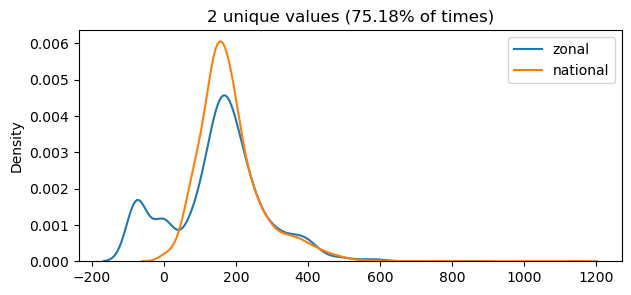

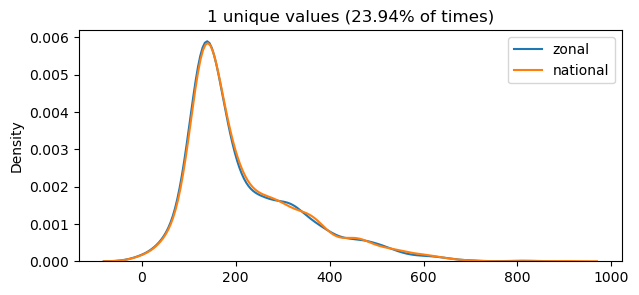

In [21]:
import seaborn as sns

for i in n_values.unique()[:2]:

    ssz = zmp.loc[n_values.loc[n_values == i].index]
    ssn = nmp.loc[n_values.loc[n_values == i].index]

    fig, ax = plt.subplots(figsize=(7, 3))

    sns.kdeplot(np.random.choice(ssz.values.flatten(), 2000), ax=ax, label='zonal')
    sns.kdeplot(np.random.choice(ssn.values.flatten(), 2000), ax=ax, label='national')

    share_of_times = np.around(100 * (ssn.shape[0] / len(nmp.index)), 2)

    ax.set_title(f'{i} unique values ({share_of_times}% of times)')

    ax.legend()
    plt.show()



In [22]:
(zmp < 0).any(axis=1).sum() / len(zmp)

0.38507589327802394

In [23]:
nmp.columns = nmp.columns.get_level_values(1)

In [24]:
zmp.columns = zmp.columns.get_level_values(1)

In [145]:
def classify_period(nat, lmp):

    nat = nat.copy()
    lmp = lmp.copy()

    nat_negative_mask = nat.loc[nat.iloc[:,0] <= 0].index

    nat_negative_prices = {
        'national': nat.loc[nat_negative_mask],
        'zonal': lmp.loc[nat_negative_mask],
    }

    lmp.drop(nat_negative_mask, inplace=True)
    nat.drop(nat_negative_mask, inplace=True)

    all_positive_mask = lmp.loc[(lmp > 0).all(axis=1)].index

    all_positive_prices = {
        'national': nat.loc[all_positive_mask],
        'zonal': lmp.loc[all_positive_mask],
    }

    lmp.drop(all_positive_mask, inplace=True)
    nat.drop(all_positive_mask, inplace=True)

    mixed_prices = {
        'national': nat,
        'zonal': lmp,
    }

    return nat_negative_prices, all_positive_prices, mixed_prices


neg, pos, mixed = classify_period(nmp, zmp)

In [155]:

def bars_to_ax(ax, lmp, loads, weights, costs, index_groups):

    distributed_price = costs.sum().drop('wholesale') / loads.sum().sum() * 1e6 #/2

    total_load = loads.sum().sum()

    bar_kwargs = {
        'alpha': 0.8,
    }
    # Create distinct colors for each cost component.

    for j, group in enumerate(index_groups):

        cumulative_positive = 0
        cumulative_negative = 0

        for i, (cat, value) in enumerate(distributed_price.items()):

            if value >= 0:
                ax.bar(j-0.25, value, width=0.5, bottom=cumulative_positive,
                    color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
                ax.plot(
                    [j-0.25, j+0.25],
                    [cumulative_positive + value, cumulative_positive + value],
                    color='k',
                    alpha=0.5,
                    lw=0.5,
                )
                cumulative_positive += value
            else:
                ax.bar(j-0.25, value, width=0.5, bottom=cumulative_negative,
                    color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
                ax.plot(
                    [j-0.25, j+0.25],
                    [cumulative_negative + value, cumulative_negative + value],
                    color='k',
                    alpha=0.5,
                    lw=0.5,
                )
                cumulative_negative += value

        assert len(lmp[group].iloc[0].unique()) == 1, "There should be only one unique value in the group"
        lmp_group = lmp[group].mean(axis=1)

        avg = (lmp_group * loads.values.flatten()).sum() / total_load
        x_loc = j - 0.25
        bar_width = 0.5

        if avg >= 0:
            ax.bar(
                x_loc,
                avg,
                width=bar_width,
                bottom=cumulative_positive,
                align='edge',
                label="lmp_group",
                color=color_dict['wholesale'],
                **bar_kwargs,
            )
            ax.plot(
                [x_loc, x_loc + bar_width],
                [cumulative_positive + avg, cumulative_positive + avg],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
        else:
            ax.bar(
                x_loc,
                avg,
                width=bar_width,
                bottom=cumulative_negative,
                align='edge',
                label="lmp_group",
                color=color_dict['wholesale'],
                **bar_kwargs,
            )
            ax.plot(
                [x_loc, x_loc + bar_width],
                [cumulative_negative + avg, cumulative_negative + avg],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
        ax.plot(
            [x_loc, x_loc + bar_width],
            [cumulative_positive + cumulative_negative + avg, cumulative_positive + cumulative_negative + avg],
            color='r',
            alpha=0.5,
        )

In [147]:
ss = mixed['zonal'].iloc[0]

low_cost_regions = ss[ss < 0].index
high_cost_regions = ss[ss > 0].index

In [148]:
from shapely.ops import unary_union
import geopandas as gpd

def regions_to_ax(regions, ax, dark_regions):

    if not dark_regions.empty:
        gpd.GeoSeries([unary_union(regions.loc[dark_regions].geometry)]).plot(ax=ax, color='midnightblue', alpha=0.8, edgecolor='none', lw=0.5)
    gpd.GeoSeries([unary_union(regions.geometry)]).plot(ax=ax, facecolor='none', edgecolor='k', alpha=1, lw=0.3)
    ax.set_xticks([])
    ax.set_yticks([])

In [149]:
from copy import deepcopy


def get_wholesale_costs(mps, loads, lw):

    loads = loads.copy() / 2
    lw = lw.copy().loc[mps.columns].values

    # print(mps.mean(axis=1))
    weighted_row_means = (mps.mul(lw, axis=1)).sum(axis=1)# / lw.sum()
    # print(weighted_row_means)

    if len(loads.shape) > 1:
        loads = loads.sum(axis=1).values
    else:
        loads = loads.values

    return (weighted_row_means * loads).sum() / loads.sum()# / lw.loc[mps.columns].sum()


print('Warning! Double check wholesale prices')

def get_total_prices(sc, mps, loads, lw, layout):

    mps = deepcopy(mps)

    try:
        mps = mps[layout]
    except KeyError:
        pass

    costs = sc.loc[idx[mps.index, :], layout].unstack().drop(columns=['balancing_volume'])

    costs = costs.sum() / loads.loc[costs.index].sum().sum() * 1e6
    # costs.loc['wholesale'] = get_wholesale_costs(mps, loads.loc[mps.index], lw)

    return costs


get_total_prices(sc, neg['national'], loads, pd.Series(1, ['GB']), 'national')

Warning! Double check wholesale prices


bid_cost            1.152933
cfd_payments       14.349075
congestion_rent     0.000000
offer_cost          4.644587
roc_payments       24.040277
wholesale           0.000000
dtype: float64

In [169]:
def simple_bars_to_ax(ax, values):

    cumulative_positive = 0
    cumulative_negative = 0

    bar_kwargs = {
        'alpha': 0.8,
    }

    for i, (cat, value) in enumerate(values.items()):

        if value >= 0:
            ax.bar(-0.25, value, width=0.5, bottom=cumulative_positive,
                color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
            ax.plot(
                [-0.25, 0.25],
                [cumulative_positive + value, cumulative_positive + value],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
            cumulative_positive += value
        else:
            ax.bar(-0.25, value, width=0.5, bottom=cumulative_negative,
                color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
            ax.plot(
                [-0.25, 0.25],
                [cumulative_negative + value, cumulative_negative + value],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
            cumulative_negative += value
        
    total = cumulative_positive + cumulative_negative
    ax.plot(
        [-0.25, 0.25],
        [total, total],
        color='red',
        lw=2,
    )

    ax.plot(
        [-0.25, 0.25],
        [values.drop('congestion_rent').sum(), values.drop('congestion_rent').sum()],
        color='red',
        linestyle=':',
        lw=2,
    )


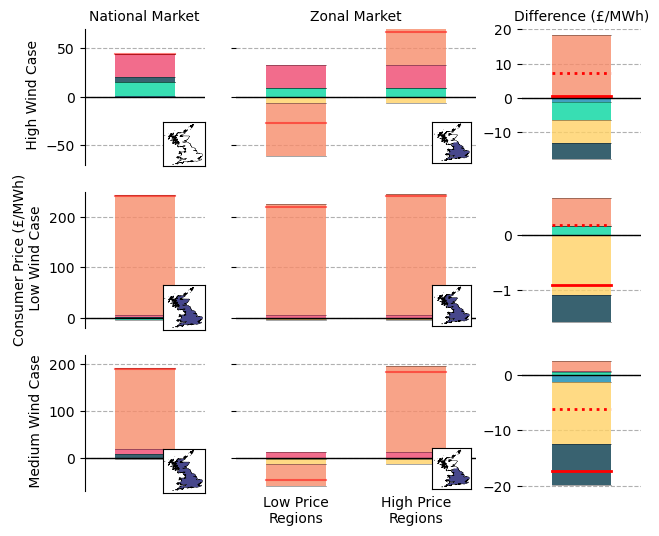

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(7, 6), gridspec_kw={'width_ratios': [1, 2, 1]})

bars_to_ax(
    axs[0,1],
    neg['zonal'],
    loads.loc[neg['zonal'].index],
    lw,
    sc.loc[idx[neg['zonal'].index, :], 'zonal'].unstack().drop(columns=['balancing_volume']),
    [low_cost_regions, high_cost_regions]
    )

bars_to_ax(
    axs[0,0],
    neg['national'],
    loads.loc[neg['national'].index],
    lw,
    sc.loc[idx[neg['national'].index, :], 'national'].unstack().drop(columns=['balancing_volume']),
    [['GB']]
    )

bars_to_ax(
    axs[1,1],
    pos['zonal'],
    loads.loc[pos['zonal'].index],
    lw,
    sc.loc[idx[pos['zonal'].index, :], 'zonal'].unstack().drop(columns=['balancing_volume']),
    [low_cost_regions, high_cost_regions]
    )

bars_to_ax(
    axs[1,0],
    pos['national'],
    loads.loc[pos['national'].index],
    lw,
    sc.loc[idx[pos['national'].index, :], 'national'].unstack().drop(columns=['balancing_volume']),
    [['GB']]
    )

bars_to_ax(
    axs[2,1],
    mixed['zonal'],
    loads.loc[mixed['zonal'].index],
    lw,
    sc.loc[idx[mixed['zonal'].index, :], 'zonal'].unstack().drop(columns=['balancing_volume']),
    [low_cost_regions, high_cost_regions]
    )

bars_to_ax(
    axs[2,0],
    mixed['national'],
    loads.loc[mixed['national'].index],
    lw,
    sc.loc[idx[mixed['national'].index, :], 'national'].unstack().drop(columns=['balancing_volume']),
    [['GB']]
    )

neg_zonal = get_total_prices(sc, neg['zonal'], loads, lw.iloc[:,0], 'zonal')
neg_national = get_total_prices(sc, neg['national'], loads, pd.Series(1, ['GB']), 'national')

neg_diff = neg_zonal - neg_national
simple_bars_to_ax(
    axs[0,2],
    neg_diff,
)

pos_zonal = get_total_prices(sc, pos['zonal'], loads, lw.iloc[:,0], 'zonal')
pos_national = get_total_prices(sc, pos['national'], loads, pd.Series(1, ['GB']), 'national')

pos_diff = pos_zonal - pos_national
simple_bars_to_ax(
    axs[1,2],
    pos_diff,
)

mixed_zonal = get_total_prices(sc, mixed['zonal'], loads, lw.iloc[:,0], 'zonal')
mixed_national = get_total_prices(sc, mixed['national'], loads, pd.Series(1, ['GB']), 'national')

mixed_diff = mixed_zonal - mixed_national
simple_bars_to_ax(
    axs[2,2],
    mixed_diff,
)

for ax in axs[:, 0]:
    ax.set_xlim(-0.5, 0.5)

for ax in axs[:, 1]:
    ax.set_xlim(-0.5, 1.5)


for ax in axs[:,1]:
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)

for ax in axs[:,2]:
    ax.spines['left'].set_visible(False)

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', axis='y')
    ax.set_axisbelow(True)

for ax in axs[0,:2]:
    ax.set_ylim(-70, 70)
for ax in axs[1,:2]:
    ax.set_ylim(-20, 250)
for ax in axs[2,:2]:
    ax.set_ylim(-70, 220)

ax_inset = axs[0,0].inset_axes([0.65, -0.1, 0.35, 0.5])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    pd.Index([])
)
ax_inset = axs[0,1].inset_axes([0.8, 0.015, 0.2, 0.3])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions,
)
ax_inset = axs[1,0].inset_axes([0.65, -0.1, 0.35, 0.5])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions.union(low_cost_regions),
)
ax_inset = axs[1,1].inset_axes([0.8, 0.015, 0.2, 0.3])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions.union(low_cost_regions),
)
ax_inset = axs[2,0].inset_axes([0.65, -0.1, 0.35, 0.5])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions.union(low_cost_regions),
)
ax_inset = axs[2,1].inset_axes([0.8, 0.015, 0.2, 0.3])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions,
)

for ax in axs[:,2]:
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([])

axs[0,0].set_ylabel('\n High Wind Case')
axs[1,0].set_ylabel('Consumer Price (£/MWh)\n Low Wind Case')
axs[2,0].set_ylabel('\n Medium Wind Case')

# labels, handles = 

for ax in axs[:,2]:
    position = ax.get_position()
    # Shift it to the right by 5% of the figure width
    new_pos = [position.x0 + 0.02, position.y0, position.width, position.height]

    ax.set_position(new_pos)

axs[0,0].set_title('National Market', fontsize=10)
axs[0,1].set_title('Zonal Market', fontsize=10)
axs[0,2].set_title('Difference (£/MWh)', fontsize=10)

axs[2,1].set_xticks([0, 1])
axs[2,1].set_xticklabels(['Low Price\nRegions', 'High Price\nRegions'])
axs[2,1].tick_params(axis='x', which='both', length=0)

for ax in axs[:2,:].flatten():
    ax.set_xticks([])

axs[2,0].set_xticks([])
axs[2,2].set_xticks([])

for ax in axs[:,:].flatten():
    ax.axhline(0, color='k', lw=1)
    ax.spines['bottom'].set_visible(False)

plt.show()

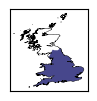

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1, 22))

regions_to_ax(
    regions.set_index('name'),
    ax,
    high_cost_regions,
)

plt.show()